# Importing the libraries

In [61]:
import time
program_start = time.time()
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
print(tf.__version__)
import math
from sklearn.metrics import mean_squared_error
import os

2.2.0


# Importing the dataset

In [62]:
yesterday = date.today() - timedelta(days = 1)
print(yesterday)
fya = yesterday - timedelta(days = 365 * 3)
print(fya)

2020-07-20
2017-07-21


In [63]:
ticker = 'TSLA'
TIINGO_API_KEY = '0d89b22b2baae6031d933255d95b27b45630fa18'
#api_key=os.environ.get('TIINGO_API_KEY')
df = pdr.get_data_tiingo(ticker, api_key=TIINGO_API_KEY, 
                         start = fya, end = yesterday)

# Data preprocessing

## Converting JSON to CSV

In [64]:
df.to_csv('{0}.csv'.format(ticker))
df.head()

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
TSLA   2017-07-21 00:00:00+00:00  328.40  331.26  ...      0.0          1.0
       2017-07-24 00:00:00+00:00  342.52  343.40  ...      0.0          1.0
       2017-07-25 00:00:00+00:00  339.60  345.60  ...      0.0          1.0
       2017-07-26 00:00:00+00:00  343.85  345.50  ...      0.0          1.0
       2017-07-27 00:00:00+00:00  334.46  347.50  ...      0.0          1.0

[5 rows x 12 columns]

## Forming dataframe of close prices

In [65]:
df1 = df.reset_index()['close']

In [66]:
df1.shape

(754,)

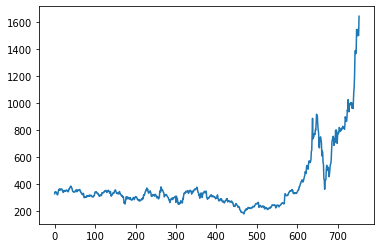

In [67]:
plt.plot(df1)

## Feature scaling using MinMax Scaler (Values between 0 to 1)

In [68]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [69]:
df1.shape

(754, 1)

## Splitting dataset into training set and test set sequentialy

In [70]:
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data, test_data = (df1[0:training_size, :], 
                         df1[training_size:len(df1), :1])
print(train_data.shape)
print(test_data.shape)

(490, 1)
(264, 1)


In [71]:
train_data

array([[0.10206758],
       [0.11171219],
       [0.1097177 ],
       [0.11262064],
       [0.10620684],
       [0.1066235 ],
       [0.09870016],
       [0.09603628],
       [0.10035313],
       [0.11483371],
       [0.12154123],
       [0.12035273],
       [0.12721734],
       [0.12606299],
       [0.12050983],
       [0.12219695],
       [0.12624741],
       [0.12524334],
       [0.1256395 ],
       [0.11813283],
       [0.11508644],
       [0.1085292 ],
       [0.11091303],
       [0.11871341],
       [0.1188227 ],
       [0.11548944],
       [0.11385696],
       [0.11501813],
       [0.11899346],
       [0.12085135],
       [0.12050983],
       [0.11654133],
       [0.11308511],
       [0.11723803],
       [0.11231327],
       [0.12617228],
       [0.12553021],
       [0.12790722],
       [0.13570077],
       [0.13718298],
       [0.14072799],
       [0.13396583],
       [0.13315301],
       [0.12807798],
       [0.1175659 ],
       [0.11339932],
       [0.11357691],
       [0.110

In [72]:
pd.DataFrame(test_data).head()

,0
0,0.038203
1,0.036973
2,0.035088
3,0.034897
4,0.040949


## Creating array of independent and dependent variables(X_train, y_train, X_test, y_test)

In [73]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[(i+time_step), 0])
  return np.array(dataX), np.array(dataY)

In [74]:
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [75]:
X_train

array([[0.10206758, 0.11171219, 0.1097177 , ..., 0.11065347, 0.1097177 ,
        0.11074227],
       [0.11171219, 0.1097177 , 0.11262064, ..., 0.1097177 , 0.11074227,
        0.11103598],
       [0.1097177 , 0.11262064, 0.10620684, ..., 0.11074227, 0.11103598,
        0.11555091],
       ...,
       [0.06447272, 0.06301783, 0.06440442, ..., 0.03051167, 0.02786145,
        0.02752676],
       [0.06301783, 0.06440442, 0.0572256 , ..., 0.02786145, 0.02752676,
        0.02996523],
       [0.06440442, 0.0572256 , 0.05801111, ..., 0.02752676, 0.02996523,
        0.03038872]])

In [76]:
print(X_train.shape)

(439, 50)


In [77]:
pd.DataFrame(y_train).head()

,0
0,0.111036
1,0.115551
2,0.120243
3,0.120462
4,0.121521


In [78]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.038203,0.036973,0.035088,0.034897,0.040949,0.040730,0.045156,0.050907,0.050142,0.051836,0.050935,0.054104,0.052396,0.055463,0.058680,0.034050,0.033517,0.038797,0.043230,0.042786,0.037486,0.037820,0.033708,0.035368,0.037192,0.040525,0.038278,0.034180,0.038271,0.027766,0.025047,0.027984,0.032691,0.032028,0.028592,0.029494,0.022151,0.024610,0.023982,0.025013,0.029193,0.031857,0.031447,0.028490,0.034569,0.033114,0.036078,0.038640,0.046536,0.045696
1,0.036973,0.035088,0.034897,0.040949,0.040730,0.045156,0.050907,0.050142,0.051836,0.050935,0.054104,0.052396,0.055463,0.058680,0.034050,0.033517,0.038797,0.043230,0.042786,0.037486,0.037820,0.033708,0.035368,0.037192,0.040525,0.038278,0.034180,0.038271,0.027766,0.025047,0.027984,0.032691,0.032028,0.028592,0.029494,0.022151,0.024610,0.023982,0.025013,0.029193,0.031857,0.031447,0.028490,0.034569,0.033114,0.036078,0.038640,0.046536,0.045696,0.045238
2,0.035088,0.034897,0.040949,0.040730,0.045156,0.050907,0.050142,0.051836,0.050935,0.054104,0.052396,0.055463,0.058680,0.034050,0.033517,0.038797,0.043230,0.042786,0.037486,0.037820,0.033708,0.035368,0.037192,0.040525,0.038278,0.034180,0.038271,0.027766,0.025047,0.027984,0.032691,0.032028,0.028592,0.029494,0.022151,0.024610,0.023982,0.025013,0.029193,0.031857,0.031447,0.028490,0.034569,0.033114,0.036078,0.038640,0.046536,0.045696,0.045238,0.043606
3,0.034897,0.040949,0.040730,0.045156,0.050907,0.050142,0.051836,0.050935,0.054104,0.052396,0.055463,0.058680,0.034050,0.033517,0.038797,0.043230,0.042786,0.037486,0.037820,0.033708,0.035368,0.037192,0.040525,0.038278,0.034180,0.038271,0.027766,0.025047,0.027984,0.032691,0.032028,0.028592,0.029494,0.022151,0.024610,0.023982,0.025013,0.029193,0.031857,0.031447,0.028490,0.034569,0.033114,0.036078,0.038640,0.046536,0.045696,0.045238,0.043606,0.044958
4,0.040949,0.040730,0.045156,0.050907,0.050142,0.051836,0.050935,0.054104,0.052396,0.055463,0.058680,0.034050,0.033517,0.038797,0.043230,0.042786,0.037486,0.037820,0.033708,0.035368,0.037192,0.040525,0.038278,0.034180,0.038271,0.027766,0.025047,0.027984,0.032691,0.032028,0.028592,0.029494,0.022151,0.024610,0.023982,0.025013,0.029193,0.031857,0.031447,0.028490,0.034569,0.033114,0.036078,0.038640,0.046536,0.045696,0.045238,0.043606,0.044958,0.044070


In [79]:
pd.DataFrame(y_test).head()

,0
0,0.045238
1,0.043606
2,0.044958
3,0.044070
4,0.046194


# Creating LSTM model

## Reshaping X_train and X_test into 3D arrays

In [80]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)

(439, 50, 1)


In [81]:
print(X_train)

[[[0.10206758]
  [0.11171219]
  [0.1097177 ]
  ...
  [0.11065347]
  [0.1097177 ]
  [0.11074227]]

 [[0.11171219]
  [0.1097177 ]
  [0.11262064]
  ...
  [0.1097177 ]
  [0.11074227]
  [0.11103598]]

 [[0.1097177 ]
  [0.11262064]
  [0.10620684]
  ...
  [0.11074227]
  [0.11103598]
  [0.11555091]]

 ...

 [[0.06447272]
  [0.06301783]
  [0.06440442]
  ...
  [0.03051167]
  [0.02786145]
  [0.02752676]]

 [[0.06301783]
  [0.06440442]
  [0.0572256 ]
  ...
  [0.02786145]
  [0.02752676]
  [0.02996523]]

 [[0.06440442]
  [0.0572256 ]
  [0.05801111]
  ...
  [0.02752676]
  [0.02996523]
  [0.03038872]]]


## Creating a sequential model

In [82]:
model = Sequential([
          LSTM(50, return_sequences=True, input_shape=(100,1)),
          LSTM(50, return_sequences=True, activation='relu'),
          LSTM(50, activation='relu'),
          Dense(1, activation='linear')
])
model.compile(loss='mean_squared_error', optimizer='adam')

In [83]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


## Training the sequential model

In [84]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=100, batch_size=64, verbose=2)

Epoch 1/100
7/7 - 2s - loss: 0.0037 - val_loss: 0.0530
Epoch 2/100
7/7 - 1s - loss: 9.5910e-04 - val_loss: 0.0468
Epoch 3/100
7/7 - 1s - loss: 6.2294e-04 - val_loss: 0.0627
Epoch 4/100
7/7 - 1s - loss: 5.7813e-04 - val_loss: 0.0507
Epoch 5/100
7/7 - 2s - loss: 4.7307e-04 - val_loss: 0.0473
Epoch 6/100
7/7 - 1s - loss: 4.2331e-04 - val_loss: 0.0435
Epoch 7/100
7/7 - 1s - loss: 3.6535e-04 - val_loss: 0.0376
Epoch 8/100
7/7 - 1s - loss: 2.9710e-04 - val_loss: 0.0321
Epoch 9/100
7/7 - 1s - loss: 2.6317e-04 - val_loss: 0.0269
Epoch 10/100
7/7 - 1s - loss: 2.5401e-04 - val_loss: 0.0253
Epoch 11/100
7/7 - 1s - loss: 2.4077e-04 - val_loss: 0.0230
Epoch 12/100
7/7 - 1s - loss: 2.4105e-04 - val_loss: 0.0231
Epoch 13/100
7/7 - 1s - loss: 2.3811e-04 - val_loss: 0.0231
Epoch 14/100
7/7 - 1s - loss: 2.3359e-04 - val_loss: 0.0231
Epoch 15/100
7/7 - 1s - loss: 2.3060e-04 - val_loss: 0.0240
Epoch 16/100
7/7 - 1s - loss: 2.3880e-04 - val_loss: 0.0239
Epoch 17/100
7/7 - 1s - loss: 2.4755e-04 - val_loss: 

## Prediction of training and test sets

In [85]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print(train_pred.shape)
print(test_pred.shape)

(439, 1)
(213, 1)


In [86]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

# Analysing training and test set results

In [87]:
math.sqrt(mean_squared_error(y_train, train_pred))

311.2688102583682

In [88]:
math.sqrt(mean_squared_error(y_test, test_pred))

537.6594516362148

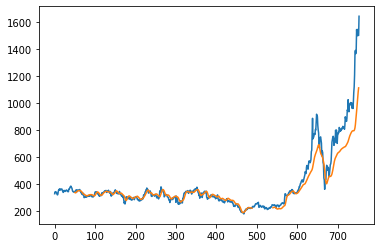

In [89]:
y_pred_plot = np.empty_like(df1)
y_pred_plot[:, :] = np.nan
y_pred_plot[time_step:len(train_pred)+time_step, :] = train_pred
y_pred_plot[len(train_pred)+(time_step*2)+1:len(df1)-1, :] = test_pred
plt.plot(scaler.inverse_transform(df1))
plt.plot(y_pred_plot)
plt.show()

In [90]:
pd.DataFrame(test_data).tail()

,0
259,0.913800
260,0.933751
261,0.902762
262,0.902898
263,1.000000


In [91]:
X_in = test_data[-100:].reshape(1, -1)
X_in.shape

(1, 100)

In [92]:
temp_in = list(X_in)
temp_in = temp_in[0].tolist()

In [93]:
pd.DataFrame(temp_in).head()

,0
0,0.341544
1,0.334023
2,0.385682
3,0.386973
4,0.389698


In [94]:
list_output = []
n_steps = 100
days_ahead = 0
while(days_ahead<30):
  if (len(temp_in) > 100):
    X_in = np.array(temp_in[1:])
    #print("{0} day input {1}".format(i, X_in))
    X_in = X_in.reshape(1, -1)
    X_in = X_in.reshape((1, n_steps, 1))
    y_hat = model.predict(X_in, verbose=0)
    #print("{0} day output {1}".format(i, y_hat))
    temp_in.extend(y_hat[0].tolist())
    temp_in = temp_in[1:]
    list_output.extend(y_hat.tolist())
    days_ahead += 1
  else:
    X_in = X_in.reshape((1, n_steps, 1))
    y_hat = model.predict(X_in, verbose=0)
    #print(y_hat)
    temp_in.extend(y_hat[0].tolist())
    #print(len(temp_in))
    list_output.extend(y_hat.tolist())
    days_ahead +=1

  pd.DataFrame(list_output).head()

In [95]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, (101+days_ahead))

In [96]:
len(df1)

754

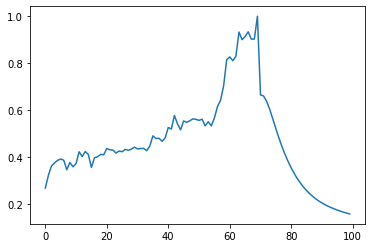

In [97]:
df3 = df1.tolist()
df3.extend(list_output)
plt.plot(df3[-100:])

In [98]:
def best_fit_slope(xs, ys):
  m = (((np.mean(xs) * np.mean(ys)) - np.mean(xs*ys))/
       ((np.mean(xs) * np.mean(xs))- np.mean(xs*xs)))
  return m

In [99]:
l_output = scaler.inverse_transform(list_output).ravel()
print(l_output)

[1153.05104549 1146.47935712 1113.14524472 1063.05026841 1003.79416182
  942.86906333  884.45831693  830.50932712  781.56748757  737.4406888
  697.87621721  662.60041607  631.24987865  603.43667735  578.7985835
  556.98842131  537.67925999  520.57006405  505.39210711  491.91477491
  479.91746663  469.19262723  459.56946125  450.87658416  442.98650475
  435.7569189   429.07909692  422.90301531  417.18070123  411.86749786]


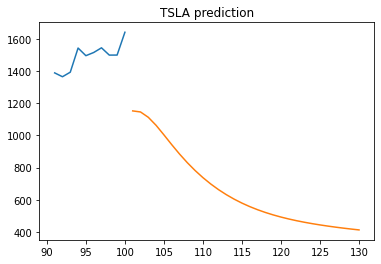

In [100]:
plt.plot(day_new[90:], scaler.inverse_transform(df1[(len(df1)-10):]))
plt.plot(day_pred, l_output)
plt.title("{0} prediction".format(ticker))
plt.show()

In [101]:
m = best_fit_slope(day_pred, l_output)
print(m)
if m < 0:
  print("short")
else:
  print("long")

-26.252400153224766
short


In [102]:
print(scaler.inverse_transform(list_output))

[[1153.05104549]
 [1146.47935712]
 [1113.14524472]
 [1063.05026841]
 [1003.79416182]
 [ 942.86906333]
 [ 884.45831693]
 [ 830.50932712]
 [ 781.56748757]
 [ 737.4406888 ]
 [ 697.87621721]
 [ 662.60041607]
 [ 631.24987865]
 [ 603.43667735]
 [ 578.7985835 ]
 [ 556.98842131]
 [ 537.67925999]
 [ 520.57006405]
 [ 505.39210711]
 [ 491.91477491]
 [ 479.91746663]
 [ 469.19262723]
 [ 459.56946125]
 [ 450.87658416]
 [ 442.98650475]
 [ 435.7569189 ]
 [ 429.07909692]
 [ 422.90301531]
 [ 417.18070123]
 [ 411.86749786]]


In [103]:
print(l_output.shape)
print(day_pred.shape)

(30,)
(30,)


In [104]:
program_end = time.time()
print(f"Runtime: {program_end - program_start}")

Runtime: 177.81356859207153
